In [1]:
import os 
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "=========="*8 + "%s" % nowtime)

### 1. 准备数据

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

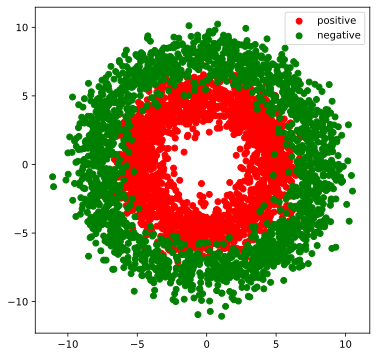

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布, label = 1
r_p = 5.0 + torch.normal(0.0, 1.0, size = [n_positive, 1]) # 离散正态分布
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis = 1)
Yp = torch.ones_like(r_p)

# 生成负样本, 大圆环分布, label = 0
r_n = 8.0 + torch.normal(0.0, 1.0, size = [n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis = 1)
Yn = torch.zeros_like(r_n)

# 汇总样本
X = torch.cat([Xp, Xn], axis = 0)
Y = torch.cat([Yp, Yn], axis = 0)

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c = 'r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c = 'g')
plt.legend(['positive', 'negative'])
plt.show()

# 样本 Xp: 2000*2 Xn: 2000*2 X: 4000*2
# 样本标签 Yp: 2000*1 Yn: 2000*1 Y: 4000*1

In [4]:
# 构建数据管道
ds = TensorDataset(X, Y)
n = n_positive + n_negative
train_size = int(n*0.7)
test_size = n - train_size
ds_train, ds_valid = torch.utils.data.random_split(ds, [train_size, test_size])
dl_train = DataLoader(ds_train, shuffle = True, batch_size = 100)
dl_valid = DataLoader(ds_valid, shuffle = True, batch_size = 100)

for features, labels in dl_train:
    print(features)
    print(labels)
    break

tensor([[  8.4859,  -4.5484],
        [  7.5524,   2.9991],
        [  1.9130,  -2.8255],
        [ -7.5531,  -3.7261],
        [  2.7460,   0.7552],
        [ -2.3075,   1.1980],
        [ -2.9000,   1.1440],
        [  8.3998,   2.3144],
        [ -4.2644,  -6.4077],
        [ -1.4177,  -2.7718],
        [  3.8659,   3.7150],
        [  2.8403,  -4.3269],
        [ -0.6674,   4.8877],
        [  7.2524,  -1.6726],
        [ -2.8752,  -5.1635],
        [  5.9049,   1.2541],
        [  0.1326,  -8.6636],
        [ -1.0478,  -7.5615],
        [  3.4709,  -6.4068],
        [  5.5317,   2.8564],
        [ -5.8023,  -4.2783],
        [ -5.6529,  -5.1286],
        [  4.2403,   3.2769],
        [  2.2606,   5.9300],
        [ -0.8360,   5.8484],
        [  5.8780,  -5.4292],
        [ -5.1430,   1.0554],
        [ -4.1610,   5.3287],
        [  7.9714,   0.5222],
        [ -3.0026,   0.6907],
        [  0.3464,  -3.9882],
        [ -0.9174,  -5.5387],
        [ -0.1065,   9.2936],
        [ 

### 2. 定义模型

In [5]:
import torchkeras
from torchkeras import Model

class DNNModel(Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y

model = DNNModel()
model.summary(input_shape=(2, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


In [6]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([4, 2])
fc1.bias 	 torch.Size([4])
fc2.weight 	 torch.Size([8, 4])
fc2.bias 	 torch.Size([8])
fc3.weight 	 torch.Size([1, 8])
fc3.bias 	 torch.Size([1])


### 3. 训练模型

In [7]:
def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred>0.5, 
                         torch.ones_like(y_pred, dtype = torch.float32), 
                         torch.zeros_like(y_pred, dtype = torch.float32))
    acc = torch.mean(1 - torch.abs(y_true - y_pred))
    return acc

In [8]:
model.compile(loss_func = nn.BCELoss(), optimizer=torch.optim.Adam(model.parameters(), lr = 0.01),
              metrics_dict={"accuracy":accuracy})
dfhistory = model.fit(epochs=100, dl_train=dl_train, dl_val=dl_valid, log_step_freq=10)

Start Training ...

================================================================================2020-12-13 20:27:50
{'step': 10, 'loss': 0.691, 'accuracy': 0.499}
{'step': 20, 'loss': 0.676, 'accuracy': 0.521}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.671 |  0.529   |   0.66   |    0.537     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:50
{'step': 10, 'loss': 0.634, 'accuracy': 0.596}
{'step': 20, 'loss': 0.626, 'accuracy': 0.597}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   2   | 0.615 |  0.631   |  0.597   |    0.685     |
+-------+-------+----------+----------+--------------+

====================================

{'step': 10, 'loss': 0.175, 'accuracy': 0.935}
{'step': 20, 'loss': 0.179, 'accuracy': 0.931}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   19  | 0.172 |  0.934   |  0.194   |    0.924     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:52
{'step': 10, 'loss': 0.187, 'accuracy': 0.93}
{'step': 20, 'loss': 0.162, 'accuracy': 0.935}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   20  | 0.167 |  0.933   |  0.201   |     0.92     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:52
{'step': 10, 'loss': 0.164, 'accuracy': 0.933}
{'step': 2


 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   37  | 0.167 |  0.931   |  0.191   |    0.916     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:53
{'step': 10, 'loss': 0.162, 'accuracy': 0.939}
{'step': 20, 'loss': 0.165, 'accuracy': 0.939}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   38  | 0.166 |  0.937   |  0.198   |    0.918     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:53
{'step': 10, 'loss': 0.164, 'accuracy': 0.942}
{'step': 20, 'loss': 0.169, 'accuracy': 0.938}

 +-------+-------+----------+----------+--------------+

{'step': 10, 'loss': 0.166, 'accuracy': 0.935}
{'step': 20, 'loss': 0.158, 'accuracy': 0.939}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   55  | 0.171 |  0.934   |  0.208   |     0.91     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:54
{'step': 10, 'loss': 0.18, 'accuracy': 0.931}
{'step': 20, 'loss': 0.178, 'accuracy': 0.929}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   56  | 0.166 |  0.935   |  0.197   |    0.915     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:54
{'step': 10, 'loss': 0.148, 'accuracy': 0.943}
{'step': 2

{'step': 20, 'loss': 0.162, 'accuracy': 0.936}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   73  | 0.161 |  0.936   |  0.213   |    0.908     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:55
{'step': 10, 'loss': 0.189, 'accuracy': 0.918}
{'step': 20, 'loss': 0.173, 'accuracy': 0.926}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   74  | 0.168 |   0.93   |  0.188   |     0.92     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:55
{'step': 10, 'loss': 0.161, 'accuracy': 0.934}
{'step': 20, 'loss': 0.162, 'accuracy': 0.935}

 +------


 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   91  | 0.172 |  0.932   |  0.202   |    0.915     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:56
{'step': 10, 'loss': 0.178, 'accuracy': 0.923}
{'step': 20, 'loss': 0.159, 'accuracy': 0.934}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   92  | 0.162 |  0.932   |  0.221   |    0.916     |
+-------+-------+----------+----------+--------------+

================================================================================2020-12-13 20:27:56
{'step': 10, 'loss': 0.165, 'accuracy': 0.941}
{'step': 20, 'loss': 0.155, 'accuracy': 0.939}

 +-------+-------+----------+----------+--------------+

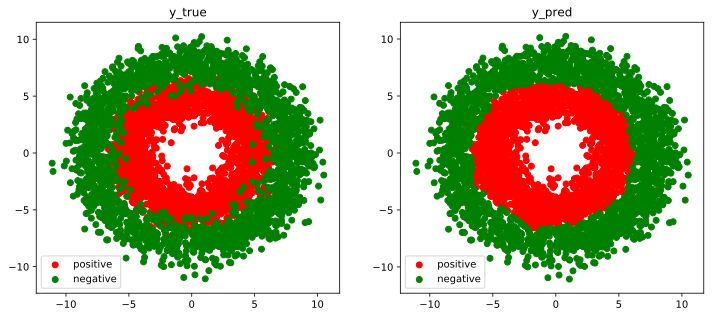

In [9]:
# 结果可视化

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c = "r")
ax1.scatter(Xn[:, 0], Xn[:, 1], c = "g")
ax1.legend(["positive", "negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1],c = "r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1],c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");
plt.show()

### 4. 评估模型

In [10]:
dfhistory.tail()

,loss,accuracy,val_loss,val_accuracy
95,0.169789,0.931071,0.208266,0.913333
96,0.167949,0.933571,0.204384,0.911667
97,0.164193,0.933571,0.191870,0.925000
98,0.160071,0.937143,0.197006,0.916667
99,0.159619,0.934643,0.207773,0.910833


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


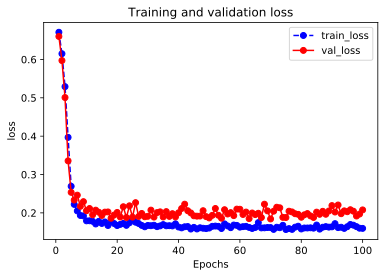

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(dfhistory, "loss")

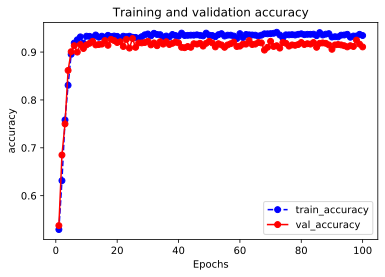

In [12]:
plot_metric(dfhistory,"accuracy")

In [13]:
model.evaluate(dl_valid)

{'val_loss': 0.2077733508000771, 'val_accuracy': 0.910833328962326}

### 5. 使用模型

In [14]:
model.predict(dl_valid)[0:10]

tensor([[0.9964],
        [0.9278],
        [0.9978],
        [0.0025],
        [0.0916],
        [0.9476],
        [0.9746],
        [0.9952],
        [0.1249],
        [0.0015]])